# Learn to Rank
https://www.tensorflow.org/ranking/tutorials/quickstart

https://www.geeksforgeeks.org/train-a-model-using-lightgbm/#
https://gist.github.com/darcyabjones/ace0934ae19c56ed4babc50167f282b0#file-ltr_presentation-ipynb
https://hav4ik.github.io/learning-to-rank/

In [241]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [228]:
# load up full data
complete = pd.read_csv('https://scmcqueen.github.io/StarTrekScriptData/complete_data.csv').reset_index()
complete.columns = ['index','line','character', 'quote', 'scene', 'location', 'view',
       'episode', 'date', 'series', 'file']
complete['quote']=complete['quote'].apply(lambda text: " ".join(text.split()))
complete['character']=complete['character'].fillna('NA')
complete['character']=complete['character'].apply(lambda x: x.replace('"','').replace('\t',''))
complete.head()

,index,line,character,quote,scene,location,view,episode,date,series,file
0,0,0,QUARK,"You know, Morn -- there's nothing quite as inv...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
1,1,1,ROM,What's this?,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
2,2,2,QUARK,"What do you mean, ""what's this?"" It's puree of...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
3,3,3,ROM,I didn't order it.,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
4,4,4,QUARK,"Of course you ""didn't order it"" -- you don't n...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt


In [229]:
# load up ratings
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)


In [230]:
# now we need to merge them

# drop the quote & unnamed 0
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
ratings.columns = ['index','query','ranking']
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
full_data = ratings.merge(complete,on=['index'],how='left')

In [231]:
full_data.head()

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file
0,66191,men,17,333,LARELL,Two men.,34 INT. QUARK'S QUARTERS,QUARK'S QUARTERS,INT.,Who Mourns for Morn?,1997-10-28,Deep Space Nine,536.txt
1,120092,men,5,171,RIKER,What about the men?,20A INT. CARGO HOLD,CARGO HOLD,INT.,Up the Long Ladder,1989-03-17,The Next Generation,144.txt
2,46258,men,1,287,EZRI,Because they're men.,38 INT. QUARK'S - ON SARINA,QUARK',INT.,Chrysalis,1998-08-14,Deep Space Nine,555.txt
3,60897,men,17,250,BASHIR,They're your own men.,64 INT. JEM'HADAR CAVERN - DAY,JEM'HADAR CAVER,INT.,Rocks and Shoals,1997-07-24,Deep Space Nine,527.txt
4,1085,men,17,237,HERBERT,And men from Mars are?,33 INT. MAGAZINE OFFICE - DAY,MAGAZINE OFFIC,INT.,Far Beyond the Stars,1997-11-14,Deep Space Nine,538.txt


In [233]:
# feature engineering
full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

quote_count = complete.groupby('character').count()['quote']

full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])


In [234]:
full_data.head()

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file,quote_len,total_quotes_char
0,66191,men,17,333,LARELL,Two men.,34 INT. QUARK'S QUARTERS,QUARK'S QUARTERS,INT.,Who Mourns for Morn?,1997-10-28,Deep Space Nine,536.txt,2,40
1,120092,men,5,171,RIKER,What about the men?,20A INT. CARGO HOLD,CARGO HOLD,INT.,Up the Long Ladder,1989-03-17,The Next Generation,144.txt,4,8138
2,46258,men,1,287,EZRI,Because they're men.,38 INT. QUARK'S - ON SARINA,QUARK',INT.,Chrysalis,1998-08-14,Deep Space Nine,555.txt,3,1050
3,60897,men,17,250,BASHIR,They're your own men.,64 INT. JEM'HADAR CAVERN - DAY,JEM'HADAR CAVER,INT.,Rocks and Shoals,1997-07-24,Deep Space Nine,527.txt,4,5474
4,1085,men,17,237,HERBERT,And men from Mars are?,33 INT. MAGAZINE OFFICE - DAY,MAGAZINE OFFIC,INT.,Far Beyond the Stars,1997-11-14,Deep Space Nine,538.txt,5,32


In [235]:
# train test split my data
train, test = train_test_split(full_data,test_size=.2,random_state=56)
# sort my train values
train = train.sort_values('query')
test = test.sort_values('query')

In [236]:
train_y = list(train['ranking']) # made a list instead of series
train_X = train.drop(columns=['query','ranking','quote','date','scene'])
groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

In [237]:
train_X.sample(2)

,index,line,character,location,view,episode,series,file,quote_len,total_quotes_char
1113,120112,191,PICARD,CORRIDOR,INT.,Up the Long Ladder,The Next Generation,144.txt,2,13445
1129,110032,64,RIKER,BRIDGE,INT.,Legacy,The Next Generation,180.txt,8,8138


In [243]:
num_attribs = list(train_X.select_dtypes(include=[np.number]))  # bill length, bill depth, body mass
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))  # species, island, sex

# takes in sequence of tuples
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])

train_prep = full_pipeline.fit_transform(train_X)


In [246]:
test_y = list(test['ranking'])
test_X = test.drop(columns=['query','ranking','quote','date','scene'])
t_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values
test_prep = full_pipeline.transform(test_X)

In [247]:
train_data =lgb.Dataset(train_prep, label=train_y, group=groups,)
valid_data = lgb.Dataset(test_prep,label=test_y,group=t_groups)

In [248]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'task':'train',
    # 'feature_pre_filter':False,
    'min_data_in_leaf':30
}
res = {}

In [249]:
ranker = lgb.train(params, train_data, num_boost_round=250,valid_sets=[valid_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

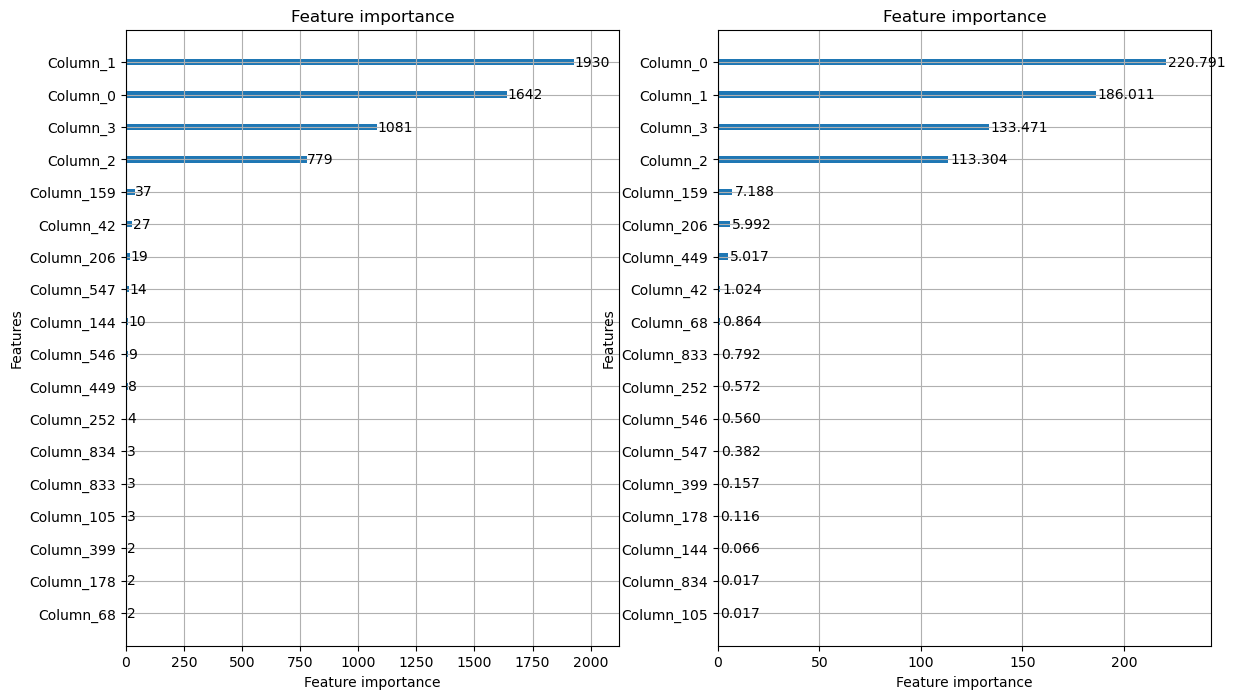

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)